In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import gpxpy.gpx

In [2]:
%matplotlib inline

In [3]:
sns.set()

In [4]:
name = 'josh'
date = datetime(2019,3,18)
filename = '{}_{}.pkl'.format(name,date.strftime('%d%b%y'))
filename

'josh_18Mar19.pkl'

In [5]:
data = pd.read_pickle('processed_data/'+filename)


In [6]:
data.reset_index(drop=True,inplace=True)

In [7]:
data.head()

,Date,Time,Lat,Lon,GPS_Alt,Pressure,Pres_Alt,Temp,Batt,Lat_Rad,...,Lat_Delta,Lon_Delta,Lat_Rad_Delta,Lon_Rad_Delta,Pres_Alt_Delta,distance,GPS_Alt_Delta,gradient,pres_gradient,grad_colour
0,03/18/2019,08:17:23,45.092552,6.061753,1814.8,1.101021e+10,1792.093,16.9,4.209,0.787014,...,-0.000008,0.000007,-1.396263e-07,1.256637e-07,NaN,1.054259,NaN,NaN,NaN,2
1,03/18/2019,08:17:24,45.092560,6.061746,1814.0,1.101021e+10,1793.184,16.9,4.112,0.787014,...,0.000000,0.000003,0.000000e+00,4.886922e-08,1.091,0.219868,-0.8,-15.367447,11.394125,0
2,03/18/2019,08:17:25,45.092560,6.061743,1816.1,1.101021e+10,1791.795,17.0,4.106,0.787014,...,-0.000004,0.000010,-6.981317e-08,1.675516e-07,-1.389,0.875338,2.1,22.627721,-32.218839,2
3,03/18/2019,08:17:26,45.092564,6.061734,1816.4,1.101021e+10,1793.084,17.0,4.125,0.787014,...,-0.000003,0.000009,-5.235988e-08,1.658063e-07,1.289,0.817212,0.3,69.841713,32.374240,0
4,03/18/2019,08:17:55,45.092567,6.061724,1816.3,1.101021e+10,1793.681,17.2,4.112,0.787014,...,-0.000119,0.000330,-2.076942e-06,5.759587e-06,0.597,29.097855,-0.1,-89.803094,88.824629,0


In [8]:
data['gps_alt_roll']=data.GPS_Alt.rolling(400).mean()
data['pres_alt_roll']=data.Pres_Alt.rolling(400).mean()

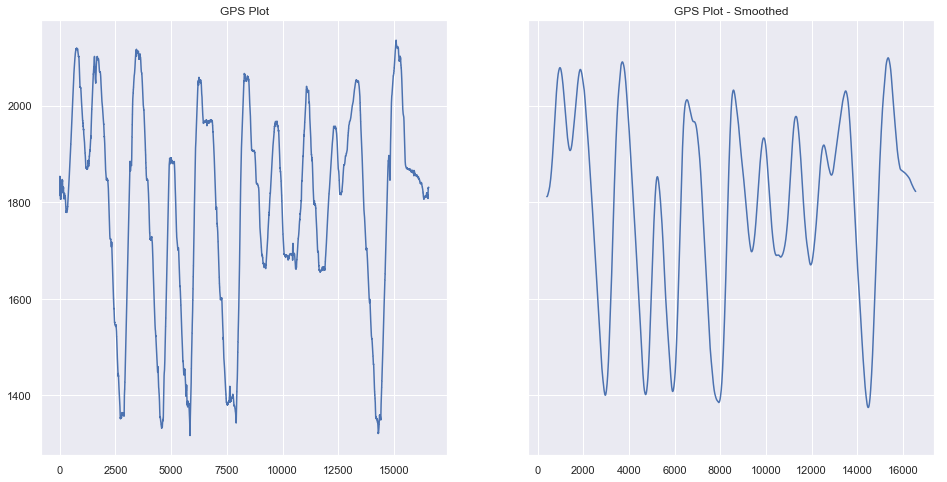

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16,8))
data.GPS_Alt.plot(ax=ax1,title='GPS Plot')
data.gps_alt_roll.plot(ax=ax2,title='GPS Plot - Smoothed')


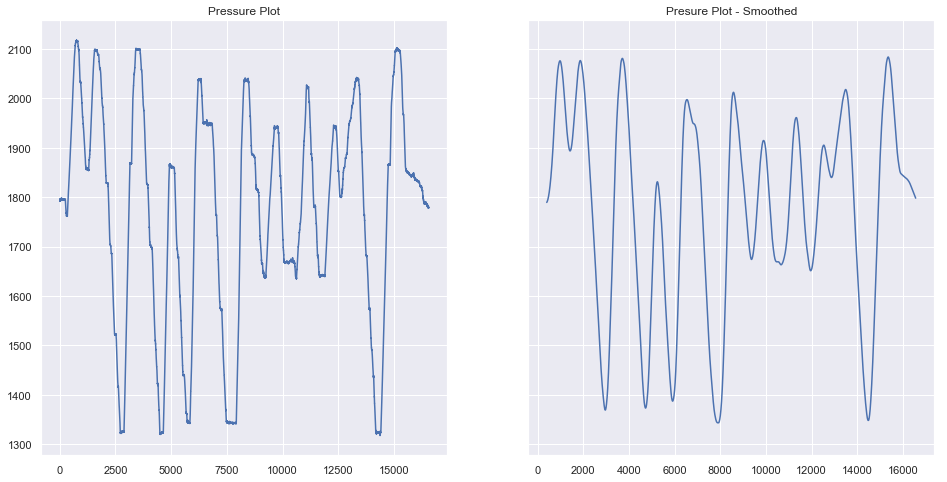

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16,8))
data.Pres_Alt.plot(ax=ax1,title='Pressure Plot')
data.pres_alt_roll.plot(ax=ax2,title='Presure Plot - Smoothed')

In [11]:
data['gps_alt_roll_delta'] = data.gps_alt_roll[:-1] - data.gps_alt_roll[1:].values
data['gps_alt_raw_delta'] = data.GPS_Alt[:-1] - data.GPS_Alt[1:].values
data['pres_alt_roll_delta'] = data.pres_alt_roll[:-1] - data.pres_alt_roll[1:].values
data['pres_alt_raw_delta'] = data.Pres_Alt[:-1] - data.Pres_Alt[1:].values

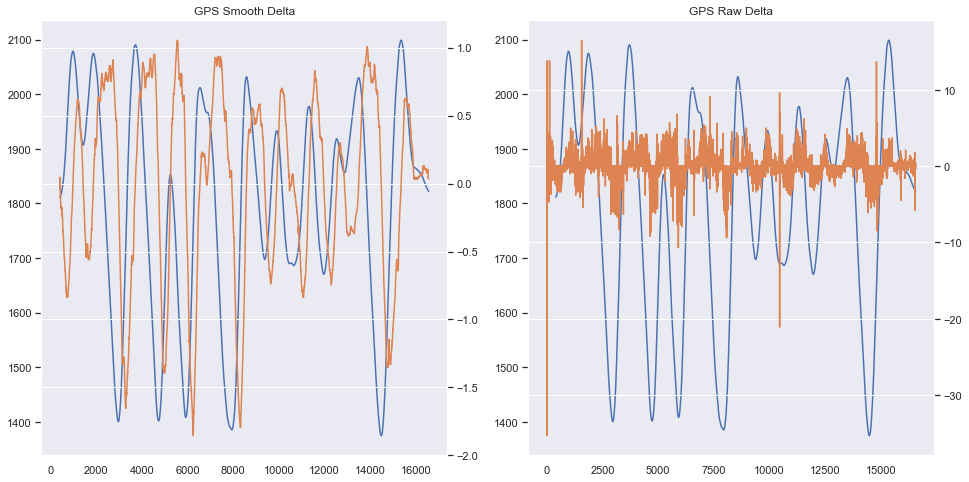

In [12]:
fig, ax= plt.subplots(1, 2, figsize=(16,8))
data.gps_alt_roll.plot(ax=ax[0],title='GPS Smooth Delta')
data.gps_alt_roll_delta.plot(ax=ax[0],secondary_y=True)
data.gps_alt_roll.plot(ax=ax[1],title='GPS Raw Delta')
data.gps_alt_raw_delta.plot(ax=ax[1],secondary_y=True)

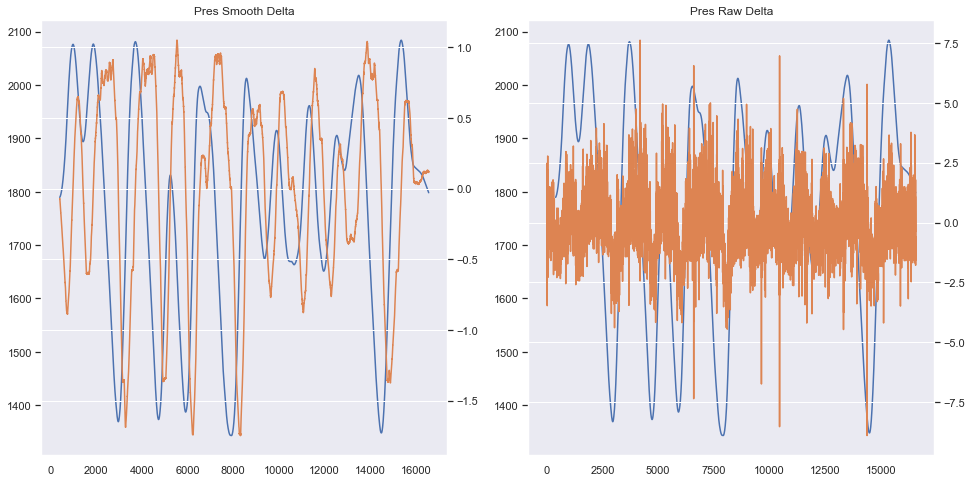

In [13]:
fig, ax= plt.subplots(1, 2, figsize=(16,8))
data.pres_alt_roll.plot(ax=ax[0],title='Pres Smooth Delta')
data.pres_alt_roll_delta.plot(ax=ax[0],secondary_y=True)
data.pres_alt_roll.plot(ax=ax[1],title='Pres Raw Delta')
data.pres_alt_raw_delta.plot(ax=ax[1],secondary_y=True)

In [14]:
#data['gps_alt_roll_delta_roll_delta'] = data.gps_alt_roll_delta_roll[:-1] - data.gps_alt_roll_delta_roll[1:].values
#data['gps_alt_roll_delta_roll_delta_roll'] =data.gps_alt_roll_delta_roll_delta.rolling(240).mean()

#data['gps_alt_raw_delta_roll_delta'] = data.gps_alt_raw_delta_roll[:-1] - data.gps_alt_raw_delta_roll[1:].values
#data['gps_alt_raw_delta_roll_delta_roll'] =data.gps_alt_raw_delta_roll_delta.rolling(240).mean()

data['gps_alt_raw_delta_roll'] =data.gps_alt_raw_delta.rolling(180).mean()
data['gps_alt_roll_delta_roll'] =data.gps_alt_roll_delta.rolling(180).mean()

data['pres_alt_raw_delta_roll'] =data.pres_alt_raw_delta.rolling(180).mean()
data['pres_alt_roll_delta_roll'] =data.pres_alt_roll_delta.rolling(180).mean()

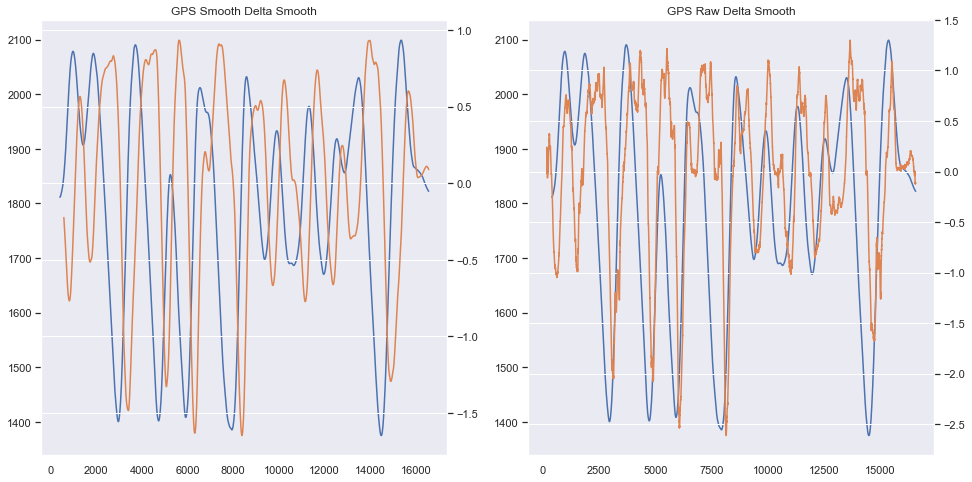

In [15]:
fig, ax= plt.subplots(1, 2, figsize=(16,8))
data.gps_alt_roll.plot(ax=ax[0],title='GPS Smooth Delta Smooth')
data.gps_alt_roll_delta_roll.plot(ax=ax[0],secondary_y=True)
data.gps_alt_roll.plot(ax=ax[1],title='GPS Raw Delta Smooth')
data.gps_alt_raw_delta_roll.plot(ax=ax[1],secondary_y=True)

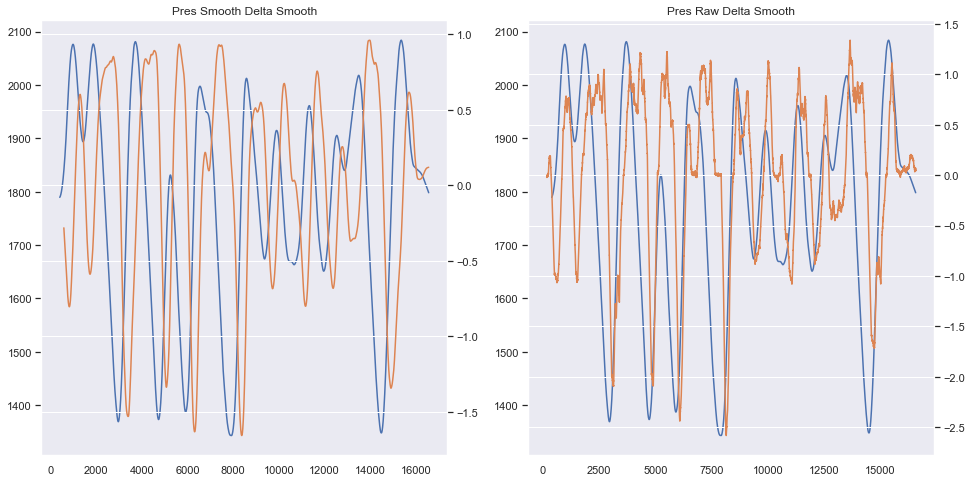

In [16]:
fig, ax= plt.subplots(1, 2, figsize=(16,8))
data.pres_alt_roll.plot(ax=ax[0],title='Pres Smooth Delta Smooth')
data.pres_alt_roll_delta_roll.plot(ax=ax[0],secondary_y=True)
data.pres_alt_roll.plot(ax=ax[1],title='Pres Raw Delta Smooth')
data.pres_alt_raw_delta_roll.plot(ax=ax[1],secondary_y=True)

In [17]:
signs = np.sign(data.gps_alt_raw_delta_roll.fillna(0))
signchange = ((np.roll(signs, 1) - signs) != 0).astype(int)

In [18]:
sign_changes_idx = signchange.index[signchange == 1].tolist()

In [19]:
routes_list=[]
for i in range(len(sign_changes_idx)-1):
    #print(sign_changes_idx[i],sign_changes_idx[i+1]-1, signs[sign_changes_idx[i]])
    start = sign_changes_idx[i]
    end = sign_changes_idx[i+1]-1
    sign = signs[sign_changes_idx[i]]
    max_val = np.max(data.loc[start:end,('gps_alt_raw_delta_roll')])
    routes_list.append((start,end,sign,max_val ))
    
routes = pd.DataFrame(routes_list,columns=['start_idx','end_idx','sign','peak'])
routes.head()

,start_idx,end_idx,sign,peak
0,179,180,-1.0,-0.012222
1,181,202,1.0,0.241667
2,203,230,-1.0,-0.002778
3,231,231,0.0,0.000000
4,232,235,-1.0,-0.001111


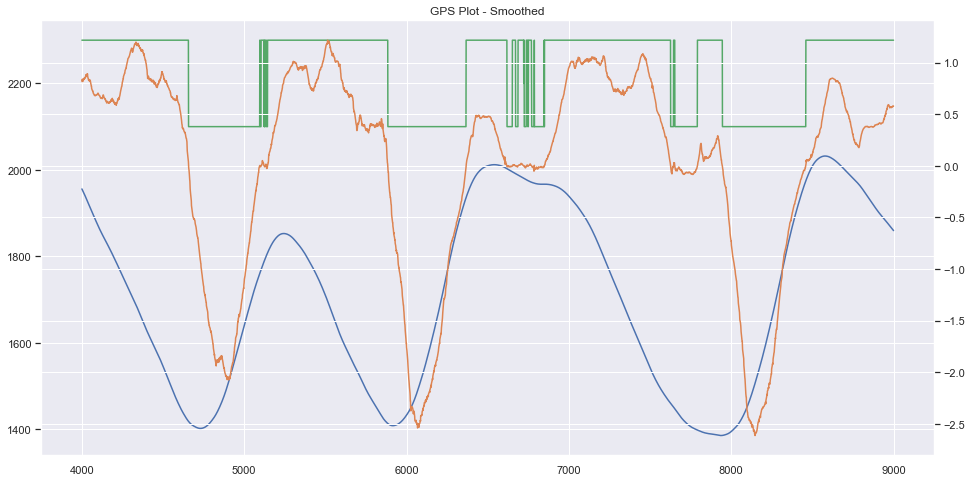

In [20]:
small_data =data.loc[4000:9000]
small_signs = signs.loc[4000:9000] *100 +2200
fig, ax= plt.subplots(1, 1, figsize=(16,8))
small_data.gps_alt_roll.plot(ax=ax,title='GPS Plot - Smoothed')
small_data.gps_alt_raw_delta_roll.plot(ax=ax,secondary_y=True)
small_signs.plot(ax=ax)

In [21]:
peak_filter = 0.5
runs = routes[(routes.sign== 1) & (routes.peak >= peak_filter)].copy()
runs.reset_index(inplace=True)
num_runs = runs.shape[0]
num_runs

11

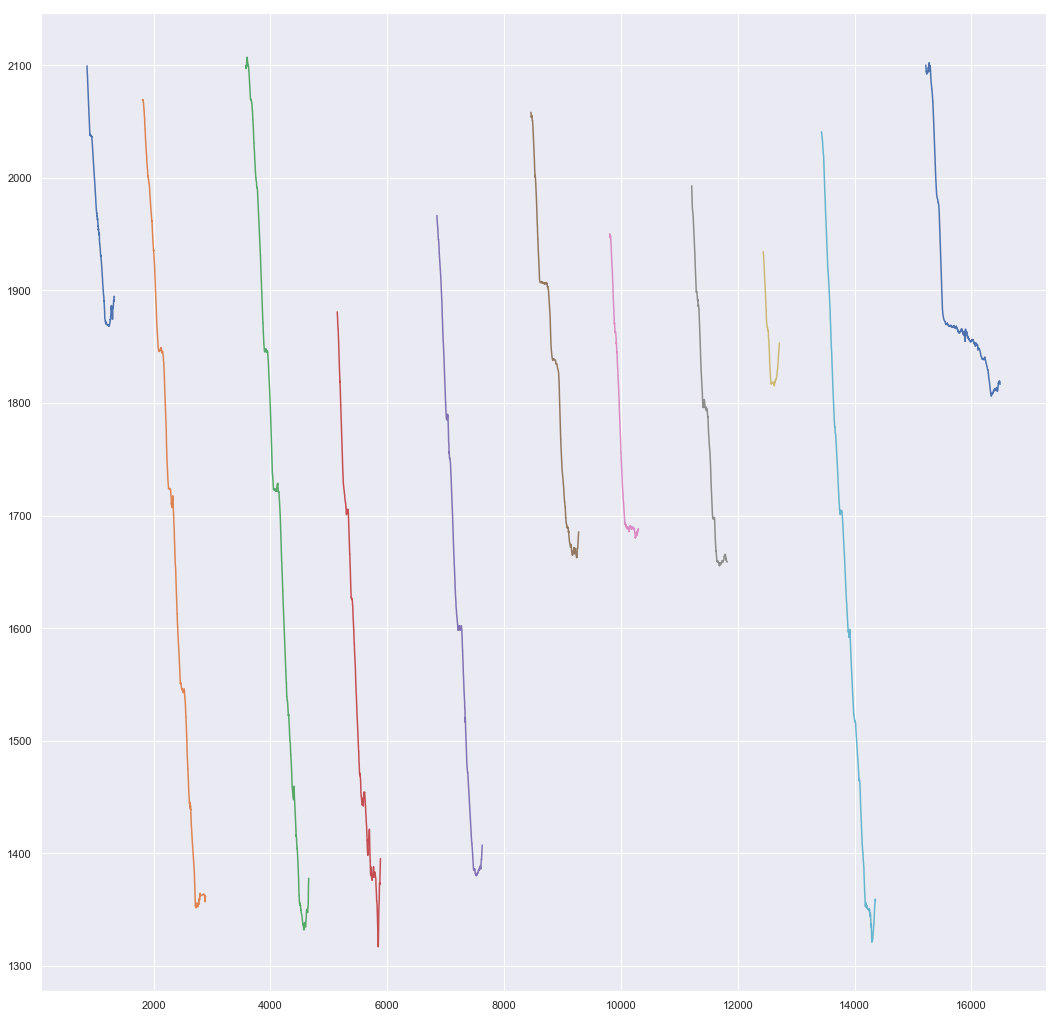

In [22]:
fig, axes= plt.subplots(1,1, figsize=(18,18))
#axes = axes.reshape(1,-1)[0]
for i in range(num_runs):
    start  =np.int(runs.loc[i].start_idx)
    end =  np.int(runs.loc[i].end_idx)
    #print(start, end)
    data.loc[start:end,('GPS_Alt')].plot(ax=axes)

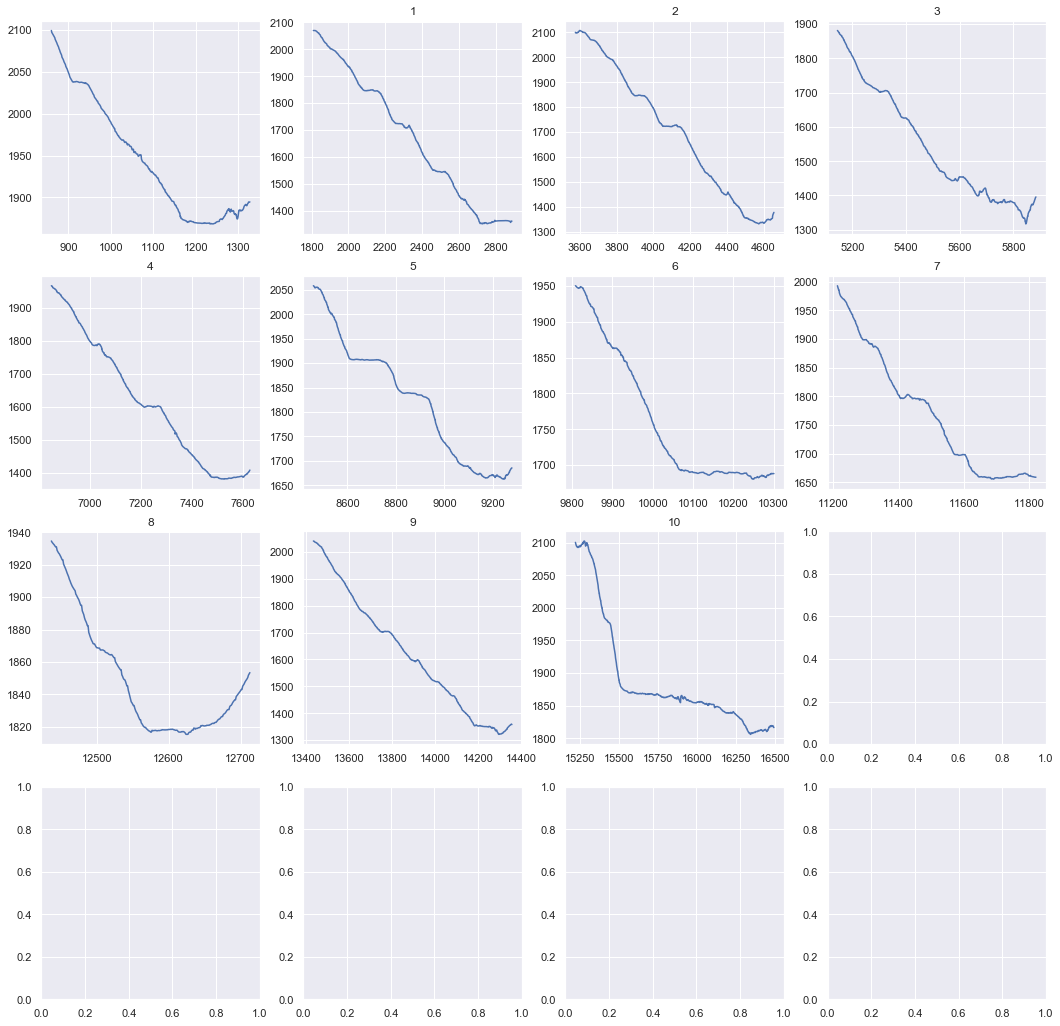

In [23]:
fig, axes= plt.subplots(4, 4, figsize=(18,18))
axes = axes.reshape(1,-1)[0]
for i in range(num_runs):
    start  =np.int(runs.loc[i].start_idx)
    end =  np.int(runs.loc[i].end_idx)
    #print(start, end)
    data.loc[start:end,('GPS_Alt')].plot(ax=axes[i], title=i)

In [24]:
data.columns.T

Index(['Date', 'Time', 'Lat', 'Lon', 'GPS_Alt', 'Pressure', 'Pres_Alt', 'Temp',
       'Batt', 'Lat_Rad', 'Lon_Rad', 'Lat_Delta', 'Lon_Delta', 'Lat_Rad_Delta',
       'Lon_Rad_Delta', 'Pres_Alt_Delta', 'distance', 'GPS_Alt_Delta',
       'gradient', 'pres_gradient', 'grad_colour', 'gps_alt_roll',
       'pres_alt_roll', 'gps_alt_roll_delta', 'gps_alt_raw_delta',
       'pres_alt_roll_delta', 'pres_alt_raw_delta', 'gps_alt_raw_delta_roll',
       'gps_alt_roll_delta_roll', 'pres_alt_raw_delta_roll',
       'pres_alt_roll_delta_roll'],
      dtype='object')

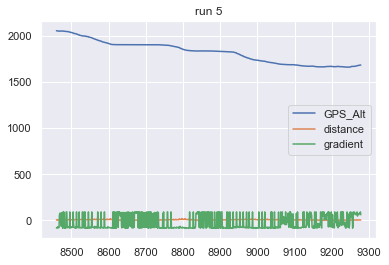

In [33]:
start  =np.int(runs.loc[5].start_idx)
end =  np.int(runs.loc[5].end_idx)
#print(start, end)
run_5 = data.loc[start:end,('GPS_Alt','distance','gradient')]
    
    
run_5.plot(title='run 5')

In [34]:
run_5.describe()

,GPS_Alt,distance,gradient
count,819.000000,819.000000,819.000000
mean,1824.390232,3.687859,-27.783146
std,119.697086,3.137065,73.561649
min,1662.600000,0.078428,-89.229217
25%,1691.300000,0.905090,-83.294721
50%,1838.100000,3.068758,-76.195375
75%,1906.800000,5.597928,67.511076
max,2058.200000,17.307614,89.999927


In [27]:
total_height = run_5.GPS_Alt.max() - run_5.GPS_Alt.min()
total_height

395.5999999999999

In [28]:
total_distance = run_5.distance.sum()
total_distance

3020.3568471546155

In [29]:
total_distance / total_height

7.634875751149181

In [35]:
run_5['distance_cum'] =run_5.distance.cumsum()


In [58]:
from skitracker_utils import calc_grad_roll_colour

In [55]:
run_5['grad_roll'] =run_5.gradient.rolling(20).mean()

In [59]:
run_5['grad_colour'] = run_5.apply(calc_grad_roll_colour, axis=1,grad_field = 'grad_roll')

In [64]:
cmap = {1:'g',2:'b',0:'r'}
run_5['grad_colour_c'] = run_5.apply(lambda x:cmap[x.grad_colour] ,axis=1)

In [65]:
run_5.tail()

,GPS_Alt,distance,gradient,distance_cum,grad_roll,grad_colour,grad_colour_c
9274,1683.8,1.974348,70.478172,3011.149360,57.070770,1,g
9275,1684.3,3.599247,82.091204,3014.748607,57.045984,1,g
9276,1684.8,2.360253,78.039194,3017.108860,65.306800,1,g
9277,1684.8,1.900437,89.999699,3019.009298,73.293887,1,g
9278,1685.6,1.347550,59.303658,3020.356847,72.081378,1,g


[]

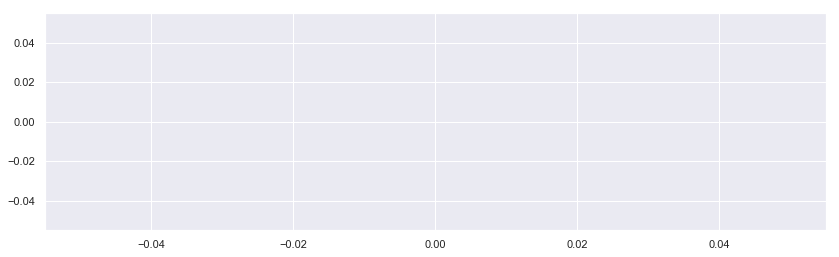

In [71]:
fig, axes= plt.subplots(1, 1, figsize=(14,4))
#run_5.GPS_Alt.plot(ax=axes)
#run_5.grad_roll.plot(ax=axes,secondary_y=True,c=run_5['grad_colour_c'] )
plt.plot(x=run_5.index,y=run_5.grad_roll,c=run_5.grad_colour_c)
